In [1]:
## Multi Layer Perceptron with MNIST DATA

In [2]:
#### Model Import

In [3]:
import numpy as np # 선형 대수와 관련된 함수를 쉽게 이용할 수 있느 모듈
import matplotlib.pyplot as plt # 함수 실행 결과 산출물에 대한 수치를 시각화 할 수 있는 외부 모듈

import torch # 파이토치의 기본 모듈
import torch.nn as nn # 파이토치 모듈 중 딥러닝 모델을 설계할 때 필요한 함수를 모아 놓은 모듈
import torch.nn.functional as F # 위 모둘 즁에서도 자주 이용되는 함수를 F로 지정
from torchvision import transforms, datasets # 컴퓨터 비전 연구 분야 중 자주 이용하는 torchvision 모듈 내 두 함수를 임포트

In [4]:
# 파이토치 프레임워크를 이용해 딥러닝 모델을 설계할 때 파라미터 값을 업데이트할 때 이용하는 장비 선택
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
# GPU를 사용할 수 있다면 Device 가 cuda 로 출력

Using PyTorch version: 1.11.0  Device: cuda


In [5]:
BATCH_SIZE = 32 # MLP 모델을 학습할 때 필요한 데이터 개수의 단위
                # Mini-batch 1개 단위에 데이터가 32개로 구성됨 - 1개의 mini-Batch를 이용해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습하는 횟수를 'epoch'
                # 만약 10,000개 data, 1,000개 batch_size라면, 1 epoch 당 10회의 Iteration 발생
EPOCHS = 10 # 존재하고 있는 Mini-batch를 전부 이용하는 횟수 = 전체 데이터셋을 10번 반복해 학습

In [6]:
# MNIST Dataset Download
train_dataset = datasets.MNIST(root = "./data/MNIST", # 데이터가 저장될 장소
                               train = True, # 대상 데이터가 학습용은지, 학습 이후 성능 검증용인지 지정
                               download = True, # 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지 지정
                               transform = transforms.ToTensor()) # 이미지 데이터에 대한 전처리 진행, 픽셀 범위를 0~1 사이로 정규화
                               # Input 데이터 값의 크기가 커질수록 불안정하거나 과적합되는 방향으로 학습이 진행될 우려가 있으므로 정규화 권장

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

# 다운로드한 MNIST 데이터셋을 Mini-Batch 단위로 분리해 지정, Batch Size만큼, 1개의 Mini-Batch를 구성하는 것을 DataLoader 함수를 이용해 진행
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, # Mini-Batch 단위로 할당하고자 하는 데이터셋 지정
                                           batch_size = BATCH_SIZE, # Mini-Batch 1개 단위를 구성하는 데이터의 개수
                                           shuffle = True) # 데이터의 순서를 섞어 특정 Label의 매칭된 이미지 데이터의 특징을 보고 학습하지 않게 함

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False) # 검증용 데이터는 섞을 필요 없음

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



In [7]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
# X_train : torch.Size([32, 1, 28, 28]) type: torch.FloatTensor → 32개의 이미지 데이터가 1개의 Mini-Batch를 구성하며, 가로 28 세로 28 1 채널(=흑백) 이미지 데이터
# y_train : torch.Size([32]) type: torch.LongTensor → 32개의 이미지 데이터 각각에 label 값이 1개씩 존재하는 32개의 데이터

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


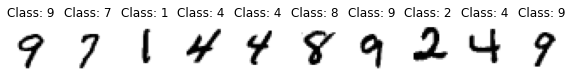

In [8]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [9]:
class Net(nn.Module): # PyTorch 모듈 내 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속
    def __init__(self): # Net 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의
        super(Net, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer, MNIST 데이터를 Input으로 사용하기 위한 크기의 노드 수 설정, Output은 다음 층의 Input과 마줓ㅁ
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer
        self.fc3 = nn.Linear(256, 10) # 마지막 Fully Connected Layer, 10가지 클래스를 표한하기 위한 Label 값은 원-핫 인코딩으로 표현됨

    def forward(self, x): # Net 클래스를 이용해 설계한 MLP 모델의 Forward Propagation을 정의. 즉, 설계한 모델에 데이터를 입력했을 때 Output을 계산하기까지의 과정
        x = x.view(-1, 28 * 28) # MLP 모델은 1차원 벡터 값을 입력으로 받으므로, 2차원 데이터를 1차원으로 변환하기 위해 view 메서드를 활용해 Flatten
        x = self.fc1(x) # __init__ method를 이용해 정의한 첫 번째 FCL에 1차원으로 펼쳐진 이미지 데이터를 통과시킴
        x = F.sigmoid(x) # 비선형 함수 시그모이드를 이용해 두 번째 FCL의 Input 계산
        x = self.fc2(x) # __init__ method를 이용해 정의된 두 번째 FCL에 이전의 시그모이드를 통해 계산된 결과값을 통과시킴
        x = F.sigmoid(x) # 위와 동일
        x = self.fc3(x) # 위와 동일
        x = F.log_softmax(x, dim = 1) # 최종 Output 계산, log_softmax()를 통해 MLP 모델이 역전파 알고리즘을 이용해 학습을 진행할 때, Loss 값에 대한 Gradient 값을 원활하게 계산 가능
        return x

In [10]:
model = Net().to(DEVICE) # 정의된 MLP 모델을 기존에 선정한 DEVICE에 할당
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
# Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 옵티마이저 정의 = 학습률: 0.01, 관성: 0.5
criterion = nn.CrossEntropyLoss()
# MLP 모델의 Output 값과 원-핫 인코딩 값과의 Loss는 CrossEntropy를 이용해 계산

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
def train(model, train_loader, optimizer, log_interval):
    model.train() # 기존에 정의한 MLP 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader): # 기존에 정의한 'train_loader'에는 이미지와 레이블이 Mini-batch 단위로 묶여있음
        image = image.to(DEVICE) # Mini-Batch 내에 있느 이미지 데이터를 기존에 정의한 장비에 할당
        label = label.to(DEVICE) # 매칭된 레이블 데이터도 기존에 정의한 장비에 할당
        optimizer.zero_grad() # 기존에 정의한 장비에 데이터를 할당할 경우, 과거에 이용한 Mini-Batch 내에 있는 데이터를 바탕으로 계산된 Loss의 Gradient 값이 optimizer에 할당돼 있으므로 Optimizer의 Gradient 초기화
        output = model(image) # 장비에 할당된 이미지 데이터를 MLP 모델의 Input으로 이용해 Output 계산
        loss = criterion(output, label) # 계산된 Output과 레이블 데이터를 기존에 정의한 Crossentropy를 이용해 Loss 값 계산
        loss.backward() # Loss 값을 바탕으로 역전파를 통해 계산된 Gradient 값을 각 파라미터에 할당
        optimizer.step() # 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
def evaluate(model, test_loader):
    model.eval() # 학습 과정 또는 학습이 완료된 MLP 모델을 학습 상태가 아닌 평가 상태로 지정
    test_loss = 0 # 기존에 정의한 'test_loader' 내의 데이터를 이용해 Loss 값 계산을 위해 'test_loss'를 임시로 0으로 설정
    correct = 0 # 올바른 Class로 분류한 경우를 세기 위해 correct = 0 으로 임시 설정

    with torch.no_grad(): # 평가 단계에서 Gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지
        for image, label in test_loader: # 'train-loader'와 동일하게 Mini-Batch 단위로 저장돼 있음
            image = image.to(DEVICE) # Mini-Batch 내의 데이터를 기존에 정의한 장비에 할당
            label = label.to(DEVICE) # 위와 동일
            output = model(image) # 장비에 할당된 이미지 데이터를 MLP 모델의 Input으로 Output 계산
            test_loss += criterion(output, label).item() # 계산된 Output과 할당된 레이블로 CrossEntropy를 이용해 Loss 값 계산 결과를 test_loss에 더해 업데이트 
            prediction = output.max(1, keepdim = True)[1] # Output 값은 크기가 10인 벡터, 계산된 벡터 값 내 가장 큰 값인 위치에 해당하는 위치에 대응하는 클래스로 예측
            correct += prediction.eq(label.view_as(prediction)).sum().item() # MLP 모델이 최종으로 예측한 클래스가 실제와 같으면 횟수 저장
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE) # 현재까지 계산된 test_loss 값을 test_loader 내 존재하는 Mini-Batch 개수만큼 나눠 평균 Loss 값 계싼
    test_accuracy = 100. * correct / len(test_loader.dataset) # test_loader 데이터 중 얼마나 맞췄는지 계산해 정확도 계산
    return test_loss, test_accuracy

In [13]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # log_interval 은 학습이 진행되면서 Mini-Batch의 Index를 이용해 과정을 모니터링할 수 있도록 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

c:\Users\lucky\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.289948
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.296746
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.313389
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.355923
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.277783
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.262803
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.314066
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.255629
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.290044
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.222328

[EPOCH: 1], 	Test Loss: 2.2355, 	Test Accuracy: 19.68 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.213917
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.195804
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.147395
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.031934
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.052812
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.919295
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.640611
T